In [2]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    directory="/kaggle/input/ultrasonic-sensor-quality-inspection/data",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    seed = 2,
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,

    validation_split = 0.2,
    subset = "training",
)

Found 1101 files belonging to 2 classes.
Using 881 files for training.


In [3]:
val_dataset = image_dataset_from_directory(
    directory="/kaggle/input/ultrasonic-sensor-quality-inspection/data",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    seed = 2,
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,

    validation_split = 0.2,
    subset = "validation",
)

Found 1101 files belonging to 2 classes.
Using 220 files for validation.


In [4]:
class_names=train_dataset.class_names
class_names_val=val_dataset.class_names
print(class_names)
print(class_names_val)

['Anomaly', 'Normal']
['Anomaly', 'Normal']


1


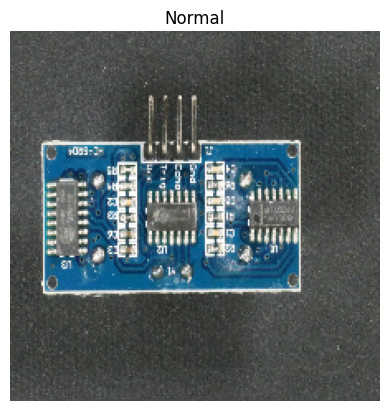

1


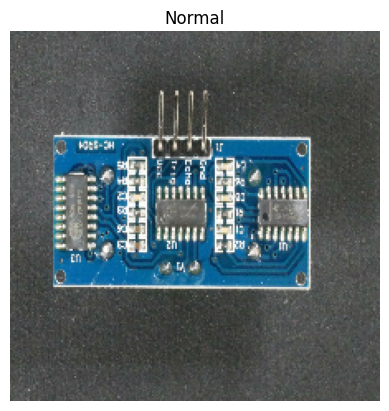

1


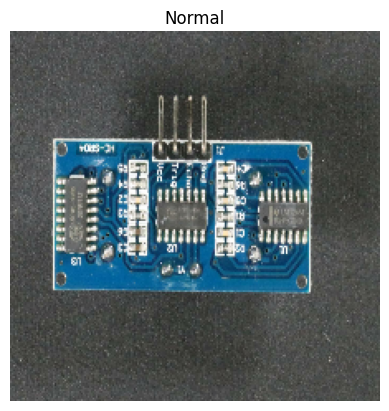

0


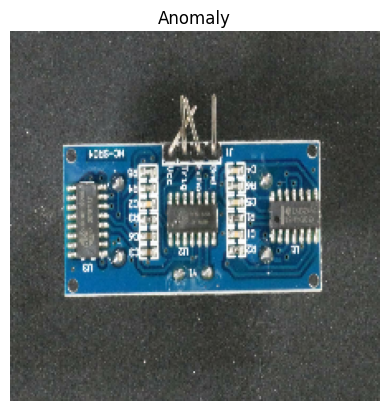

1


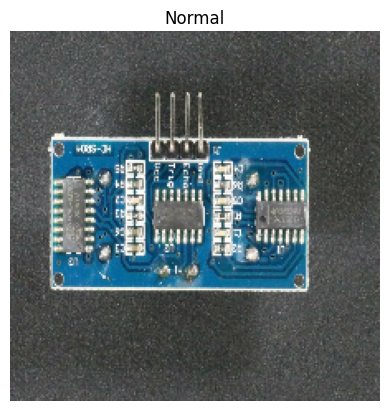

1


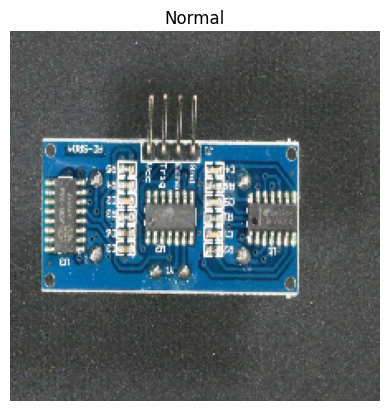

1


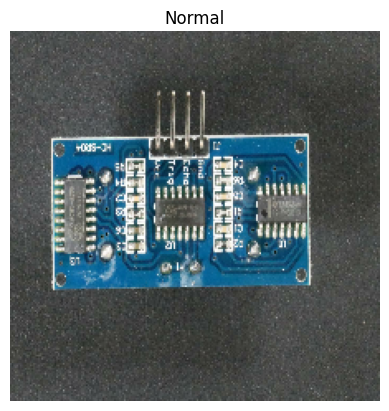

1


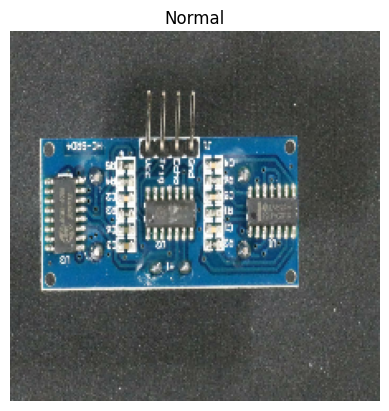

0


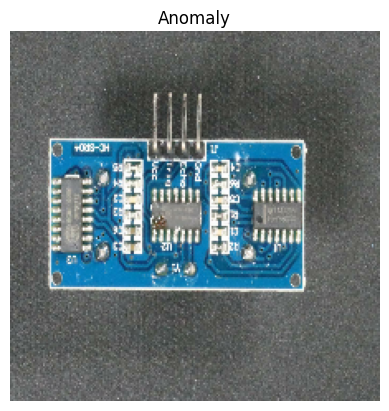

1


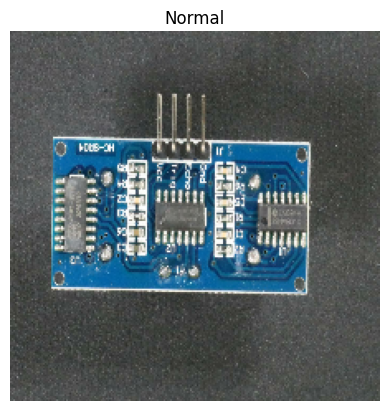

1


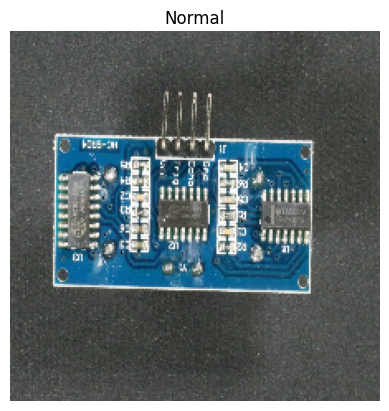

1


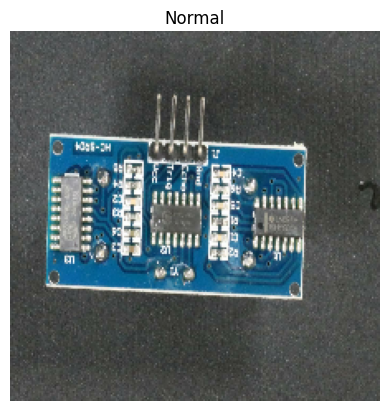

1


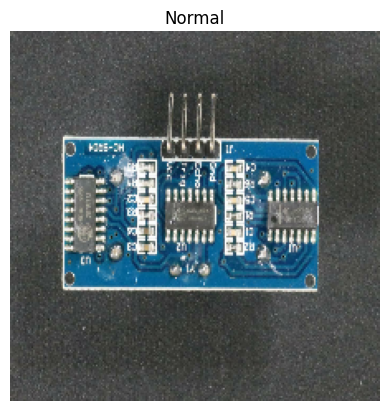

1


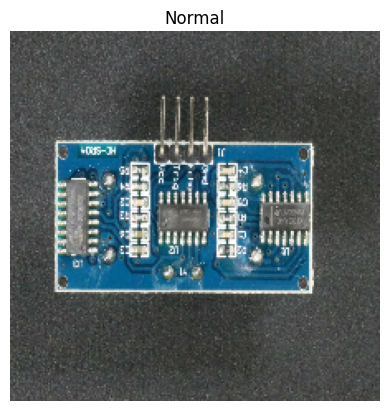

1


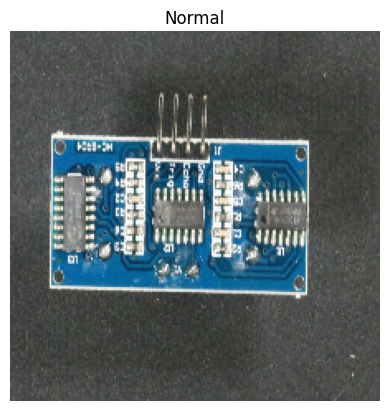

1


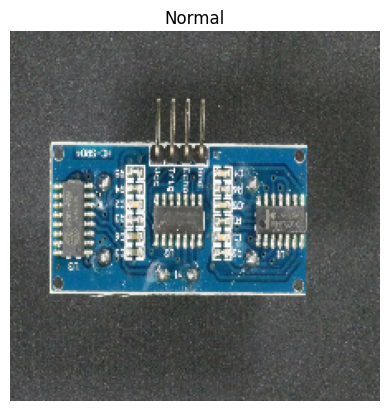

1


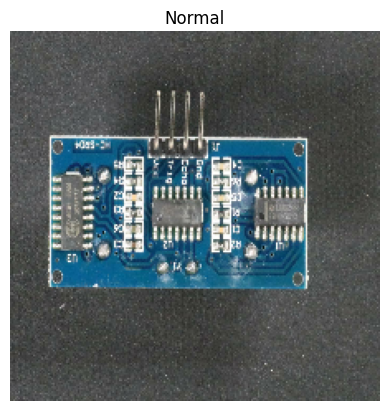

1


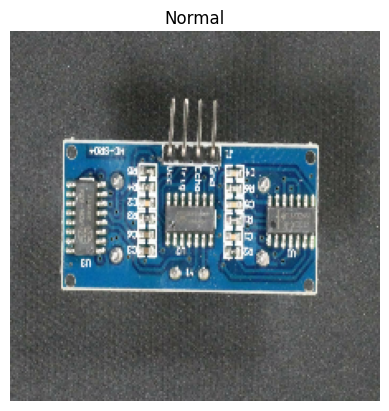

1


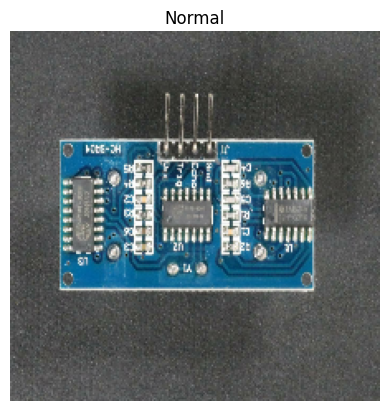

In [5]:
import matplotlib.pyplot as plt
import numpy as np
for  images, labels in train_dataset.take(1):
    for idx in range(16):
        image=images[idx].numpy().astype(np.uint8)
        label=labels[idx].numpy()
        label=int(label[0])
        class_name=class_names[label]        
        
        print(label)
        plt.imshow(image)
        plt.axis("off")
        plt.title(class_name)
        plt.show()
        
    
    break;
    
    
for  images, labels in val_dataset.take(1):
    for idx in range(3):
        image=images[idx].numpy().astype(np.uint8)
        label=labels[idx].numpy()
        label=int(label[0])
        class_name=class_names[label]        
        
        print(label)
        plt.imshow(image)
        plt.axis("off")
        plt.title(class_name)
        plt.show()
        
    

In [6]:
import matplotlib.pyplot as plt

def plot_images(dataset, data_augmentation_pipeline, rows = 4, cols= 4):
    for image_batch, _ in dataset.take(1):
        plt.figure(figsize=(8, 8))

        for i in range(rows * cols):
            augmented_images = data_augmentation_pipeline(image_batch)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(augmented_images[i].numpy().astype("uint8"))
            plt.axis("off")
        plt.show()

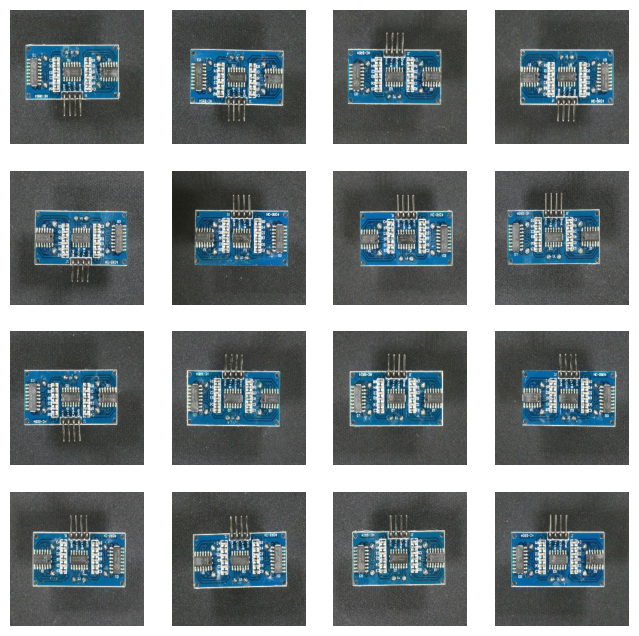

In [7]:
from keras.layers import RandomFlip 
from keras.models import Sequential

data_augmentation_pipeline = Sequential([
    RandomFlip("horizontal_and_vertical"),
])

plot_images(train_dataset, data_augmentation_pipeline)

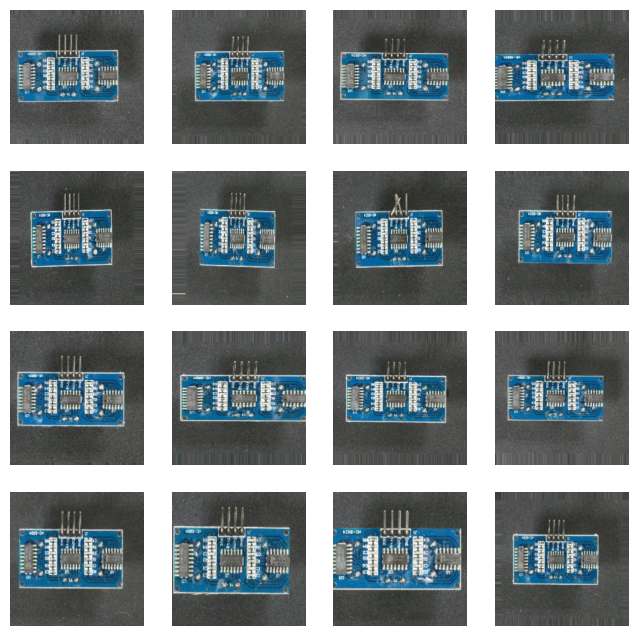

In [8]:
from keras.layers import RandomZoom 
from keras.models import Sequential

data_augmentation_pipeline = Sequential([
    RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.3, 0.3), fill_mode="nearest" ),
])

plot_images(train_dataset, data_augmentation_pipeline)

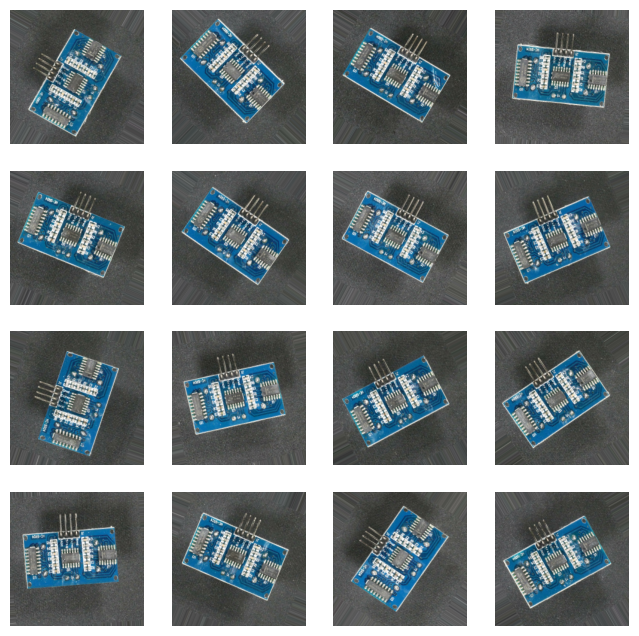

In [9]:
from keras.layers import RandomRotation
from keras.models import Sequential

data_augmentation_pipeline = Sequential([
    RandomRotation((-0.2,0.2), fill_mode="nearest", interpolation="bilinear"),
])

plot_images(train_dataset, data_augmentation_pipeline)

In [10]:
from keras.layers import Input, Rescaling
Input_layer=Input(shape=(224,224,3))
capa_normal=Rescaling(1./255)(Input_layer)


In [11]:
from keras.applications import VGG16

base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))

base_model.summary()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [ ]:
base_model.trainable = True

num_layers_fine_tune = 5
num_layers = len(base_model.layers)

for layer in base_model.layers[:num_layers - num_layers_fine_tune]:
    print(f"Layer {layer.name} will be frozen")
    layer.trainable = False

In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten, Input, RandomFlip, RandomZoom
from keras.applications.vgg16 import preprocess_input

x = preprocess_input(Input_layer)

x = RandomFlip("horizontal_and_vertical")(Input_layer)
x = RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.3, 0.3), fill_mode="nearest" )(x)
x = RandomRotation((-0.2,0.2), fill_mode="nearest", interpolation="bilinear")(x)
x = base_model(x)
x = Flatten()(x)
x = Dense(units=4096, activation="relu")(x)
x = Dense(units=2048, activation="relu")(x)
output = Dense(units=1, activation="sigmoid")(x)

model = Model(Input_layer, output)

model.summary()

In [ ]:
from keras.optimizers import Adam

adam = Adam(learning_rate=0.0005)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=5)
checkpoint = ModelCheckpoint("./best_model.keras", monitor="val_loss", save_best_only=True)

In [ ]:
history = model.fit(train_dataset, validation_data= val_dataset, epochs=50, callbacks=[early_stop, checkpoint])

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

In [ ]:
import keras.utils as utils
from keras.models import load_model

model.load_weights("./best_model.keras")
model.save("sensor.keras")

model = load_model("./sensor.keras")

In [ ]:

from PIL import Image
import numpy as np

plt.figure(figsize=(24, 24))


test_image = utils.get_file("amazon.jpg","https://www.taiwansensor.com.tw/wp-content/uploads/2018/03/NSE-1043-1_3-%E8%A4%87%E8%A3%BD-560x560.jpg")
image = utils.load_img(test_image)
image = utils.img_to_array(image)

plt.imshow(image.astype(np.uint8))

import cv2

image = cv2.resize(image, (224, 224))
image = np.expand_dims(image, axis=0)

y_pred = model.predict(image)

print(y_pred[0])

output = np.round(y_pred[0])
output = np.uint8(output)
print(output)

label = train_dataset.class_names[output[0]]
print(label)